In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

## Задача проекта

Цель проекта: выявить закономерности определяющие успешность компьютерной игры.  
Для реализации этой цели были поставлены следующие задачи:
* изучить и подготовить к анализу данные, которые содержат информацию об играх
* провести исследовательский анализ данных:
    1. оценить сколько игр выпускалось в разные годы
    2. проанализировать продажи игр в зависимости от платформы
    3. определить актуальный период развития компьютерных игр для построения прогноза
    4. исследовать глобальные продажи игр в разбивке по платформам при помощи диаграммы размаха
    5. выяснить влияние на продажи внутри одной популярной платформы отзывов пользователей и критиков (посчитать корреляцию)
    6. изучить общее распределение игр по жанрам (выделить прибыльные жанры)
* составить портрет пользователя каждого региона (NA, EU, JP) - определить топ-5 платформ, топ-5 жанров, оценить влияние рейтинга ESRB для каждого региона
* проверить гипотезы:
    1. cредние пользовательские рейтинги платформ Xbox One и PC одинаковые
    2. cредние пользовательские рейтинги жанров Action и Sports разные

## Загрузка исходных данных

Описание данных

|столбец | описание|
|:--- |:---|
|Name | название игры|
|Platform | платформа|
|Year_of_Release | год выпуска|
|Genre | жанр игры|
|NA_sales | продажи в Северной Америке (миллионы проданных копий)|
|EU_sales | продажи в Европе (миллионы проданных копий)|
|JP_sales | продажи в Японии (миллионы проданных копий)|
|Other_sales | продажи в других странах (миллионы проданных копий)|
|Critic_Score | оценка критиков (максимум 100)|
|User_Score | оценка пользователей (максимум 10)|
|Rating | рейтинг от организации ESRB|

In [2]:
games_df = pd.read_csv('/datasets/games.csv')
games_df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В исходном датафрейме 11 столбцов и 16715 строк. Пропущенные значения есть в столбцах 'Name', 'Year_of_Release', 'Genre', 'Critic_Score', 'User_Score', 'Rating'. Столбец с датой релиза игры (Year_of_Release) следует привести к типу datetime, в столбце с оценкой пользователя (User_Score) следует привести к типу float (в нем есть строковые значения).

## Предобработка исходных данных

In [4]:
games_df.columns = games_df.columns.str.lower() #приводим названия столбцов к нижнему регистру
games_df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
games_df.duplicated().sum() #ищем явные дубликаты

0

In [6]:
games_df[games_df.loc[:, ['name', 'platform', 'year_of_release']].duplicated(keep=False)] #ищем неявные дубликаты

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E


Найдено два неявных дубликаты, так как далее я обработал 1 пару дубликатов, с другой парой решено сложить продажи и удалить последнее вхождение

In [7]:
games_df.loc[604, 'eu_sales'] = 0.23 #записываем сумму продаж в строчку с первым вхождением дубликата
games_df.drop(games_df.index[16230], inplace=True) #удаляем 16230 строчку

In [8]:
games_df.isna().mean().sort_values(ascending=False) * 100 #смотрим доли пропущенных значений по столбцам

critic_score       51.322245
rating             40.481034
user_score         40.092138
year_of_release     1.609429
name                0.011966
genre               0.011966
platform            0.000000
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
dtype: float64

In [9]:
games_df[games_df['name'].isna()] #смотрим строки с пропущенными названием и жанром игры

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [10]:
games_df = games_df.dropna(subset=['name']) #удаляем строки с пропущенными названием и жанром игры
games_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16712 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16712 non-null  object 
 2   year_of_release  16443 non-null  float64
 3   genre            16712 non-null  object 
 4   na_sales         16712 non-null  float64
 5   eu_sales         16712 non-null  float64
 6   jp_sales         16712 non-null  float64
 7   other_sales      16712 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       10013 non-null  object 
 10  rating           9948 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


In [11]:
#games_df['year_of_release'] = pd.to_datetime(games_df['year_of_release'], format='%Y') #приводим столбец 'year_of_release' к типу datetime
#games_df.info()

In [12]:
games_df.loc[games_df['user_score'] == 'tbd', 'user_score'] = np.nan #заменяем аббревиатуру 'tbd' в столбце 'user_score' на пропуск
games_df['user_score'] = games_df['user_score'].astype('float') #приводим столбец 'user_score' к типу float
games_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16712 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16712 non-null  object 
 2   year_of_release  16443 non-null  float64
 3   genre            16712 non-null  object 
 4   na_sales         16712 non-null  float64
 5   eu_sales         16712 non-null  float64
 6   jp_sales         16712 non-null  float64
 7   other_sales      16712 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       7589 non-null   float64
 10  rating           9948 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


In [13]:
games_df['total_sales'] = games_df['na_sales'] + games_df['eu_sales'] + games_df['jp_sales'] + games_df['other_sales'] #считаем суммарные продажи во всех регионах
games_df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


На этапе подготовки данных были приведены названия столбцов к нижнему регистру, явных дубликатов не найдено, строки, содержащие пропуски в стобцах 'name' и 'genre' (2 строки), были удалены, т.к. они нерелевантны для исследования,  преобразованы типы данных в столбцах 'year_of_release', 'user_score' к типам datetime и float соответственно, т.к. в столбце 'year_of_release' указан год выпуска игры, а в столбце 'user_score' пользовательский рейтинг - числовое значение с плавающей точкой, помимо этого, в этом столбце есть строковое значение (2424 строки) - аббревиатура 'tbd' - подлежит уточнению. Принято решение заменить его на пустую строку, т.к. эта информация не нужна для исследования, а замена позволит привести тип данных столбца к float. В остальных столбцах пропуски не были обработаны (аналитик решил что в этом нет смысла, потому что их замена любой статистикой, в особенности когда пропусков много, может повлиять на выводы исследования). Основная масса пропусков лежит в трех столбцах: 'critic_score', 'user_score', 'rating' - все эти столбцы заполняются вручную (так сказать, экпертным мнением), в виду того что это оценки игр -> основная причина пропусков, на мой взгяд, в том, что не всем играм выставлялись рейтинг/оценки, в особенности непопулярным (с малым кол-вом продаж). Были подсчитаны суммарные продажи и записаны в отдельный столбец 'total_sales'.

In [14]:
# Комментарий ревьюера
# Посмотрим, что осталось
temp = games_df.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().mean()*100,2),'%') 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16712 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16712 non-null  object 
 2   year_of_release  16443 non-null  float64
 3   genre            16712 non-null  object 
 4   na_sales         16712 non-null  float64
 5   eu_sales         16712 non-null  float64
 6   jp_sales         16712 non-null  float64
 7   other_sales      16712 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       7589 non-null   float64
 10  rating           9948 non-null   object 
 11  total_sales      16712 non-null  float64
dtypes: float64(8), object(4)
memory usage: 1.7+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio: Instant Artist' 'wwe Smackdown vs. Raw 2006'
 '¡Shin Chan Flipa en colores!

## Исследовательский анализ данных

### Распределение количества выпущенных игр по годам

In [15]:
games_df['year_of_release'].value_counts() #смотрим кол-во выпущенных игр по годам

2008.0    1427
2009.0    1426
2010.0    1255
2007.0    1197
2011.0    1136
2006.0    1006
2005.0     939
2002.0     829
2003.0     775
2004.0     762
2012.0     652
2015.0     606
2014.0     581
2013.0     544
2016.0     502
2001.0     482
1998.0     379
2000.0     350
1999.0     338
1997.0     289
1996.0     263
1995.0     219
1994.0     121
1993.0      60
1981.0      46
1992.0      43
1991.0      41
1982.0      36
1986.0      21
1989.0      17
1983.0      17
1987.0      16
1990.0      16
1988.0      15
1984.0      14
1985.0      14
1980.0       9
Name: year_of_release, dtype: int64

В 21 веке кол-во выпущенных игр значительно увеличилось по сравнению с 20 веком. Основной пик релизов пришелся на 2008-2009 года, после этого периода идет спад. Рынок видеоигр подвержен сильным изменениям (продукты этой сферы имеют склонность к быстрому устареванию), т.к. относится к сектору информационных технологий, в связи с этим считаю актуальным взять продажи за последние 10 лет.

### Продажи игр по платформам

In [16]:
games_df.groupby('platform')['total_sales'].sum().sort_values(ascending=False) #топ платформ по суммарным продажам

platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
3DS      259.00
XB       257.74
GB       255.46
NES      251.05
N64      218.68
SNES     200.04
GC       198.93
XOne     159.32
2600      96.98
WiiU      82.19
PSV       54.07
SAT       33.59
GEN       28.35
DC        15.95
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: total_sales, dtype: float64

Топ-5 платформ по суммарным продажам: PS2, X360, PS3, Wii, DS

#### Продажи по годам на топ-5 платформ по объему игр

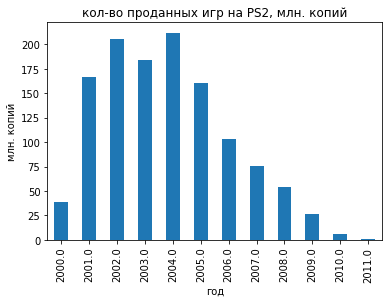

In [17]:
games_df.query('platform == "PS2"').groupby('year_of_release')['total_sales'].sum().plot.bar(title='кол-во проданных игр на PS2, млн. копий', xlabel='год', ylabel='млн. копий')
plt.show()

<AxesSubplot:title={'center':'кол-во проданных игр на PS3, млн. копий'}, xlabel='год', ylabel='млн. копий'>

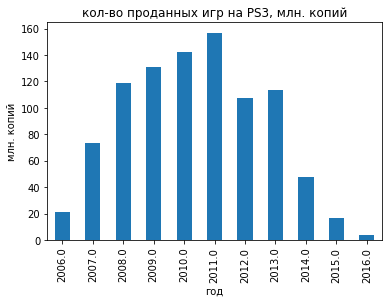

In [19]:
games_df.query('platform == "PS3"').groupby('year_of_release')['total_sales'].sum().plot.bar(title='кол-во проданных игр на PS3, млн. копий', xlabel='год', ylabel='млн. копий')

<AxesSubplot:title={'center':'кол-во проданных игр на Wii, млн. копий'}, xlabel='год', ylabel='млн. копий'>

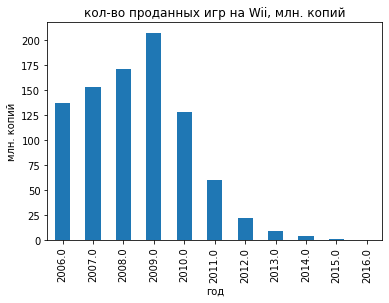

In [20]:
games_df.query('platform == "Wii"').groupby('year_of_release')['total_sales'].sum().plot.bar(title='кол-во проданных игр на Wii, млн. копий', xlabel='год', ylabel='млн. копий')

<AxesSubplot:title={'center':'кол-во проданных игр на DS, млн. копий'}, xlabel='год', ylabel='млн. копий'>

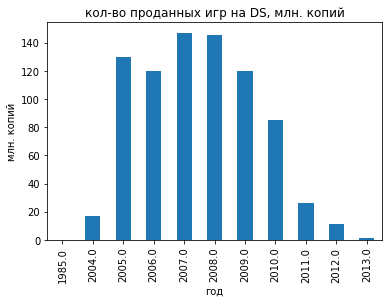

In [21]:
games_df.query('platform == "DS"').groupby('year_of_release')['total_sales'].sum().plot.bar(title='кол-во проданных игр на DS, млн. копий', xlabel='год', ylabel='млн. копий')

Тут найдена ошибка: в 1985 году платформы DS еще не существовало, однако на диаграмме видим что есть продажи

In [22]:
games_df.query('platform == "DS" and year_of_release == 1985')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985.0,Action,0.0,0.0,0.02,0.0,NaN,NaN,NaN,0.02


#### Срок актуальности платформы

~Исходя из графиков распределения продаж по годам на топ-5 платформах можно сделать вывод, что в среднем срок актуальности платформы составляет 9-10 лет, после этого платформа устаревает.~

In [23]:
time_life = games_df.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']).reset_index()
time_life['life'] = time_life['max'] - time_life['min'] + 1

time_life['life'].median()

7.0

Срок жизни игровой платформы в среднем составляет 7 лет

In [24]:
# Комментарий ревьюера
temp = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
temp.columns = temp.columns.str.lower()
temp.year_of_release = temp.year_of_release.astype('Int64')

time_life = temp.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']).reset_index()
time_life['life'] = time_life['max'] - time_life['min'] + 1 # в срок жизни платформы, должны входить границы диапазона, 
                                                            # поэтому +1
time_life['life'].median()

7.0

### Подготовка данных за актуальный период

In [25]:
#rel_games_df = games_df.query('year_of_release > 2005') #создаем датафрейм с релизом игр после 2005 года
rel_games_df = games_df.query('year_of_release > 2011')
display(rel_games_df.head())
rel_games_df.info()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013.0,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013.0,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013.0,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
34,Call of Duty: Black Ops II,PS3,2012.0,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2885 entries, 16 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2885 non-null   object 
 1   platform         2885 non-null   object 
 2   year_of_release  2885 non-null   float64
 3   genre            2885 non-null   object 
 4   na_sales         2885 non-null   float64
 5   eu_sales         2885 non-null   float64
 6   jp_sales         2885 non-null   float64
 7   other_sales      2885 non-null   float64
 8   critic_score     1311 non-null   float64
 9   user_score       1530 non-null   float64
 10  rating           1610 non-null   object 
 11  total_sales      2885 non-null   float64
dtypes: float64(8), object(4)
memory usage: 293.0+ KB


### Топ платформ за актуальный период

In [26]:
rel_games_df.groupby('platform')['total_sales'].sum().sort_values(ascending=False) #топ платформ по продажам за актуальный период

platform
PS4     314.14
PS3     288.79
X360    236.54
3DS     194.61
XOne    159.32
WiiU     82.19
PC       62.65
PSV      49.18
Wii      35.37
DS       12.55
PSP      11.19
Name: total_sales, dtype: float64

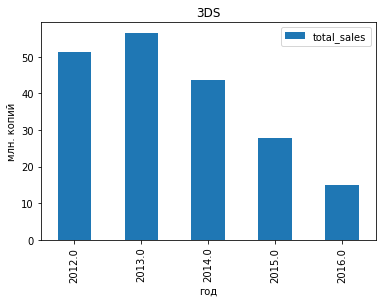

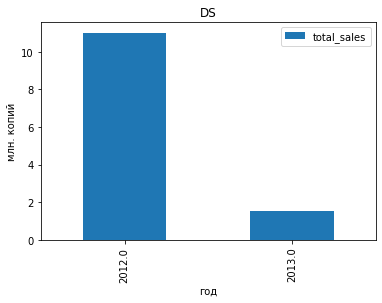

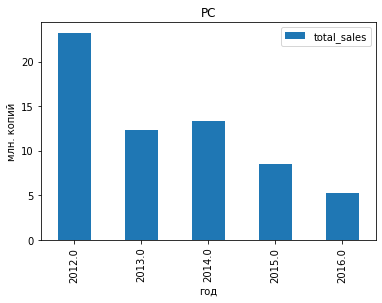

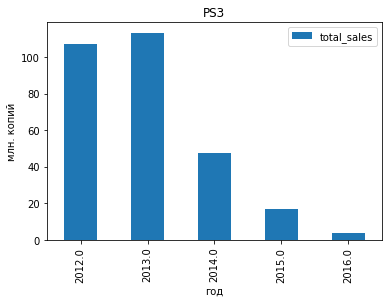

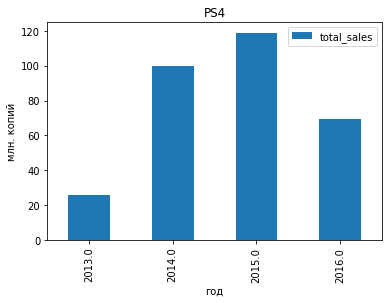

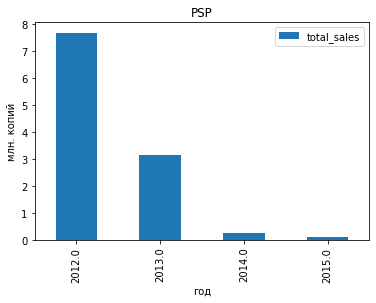

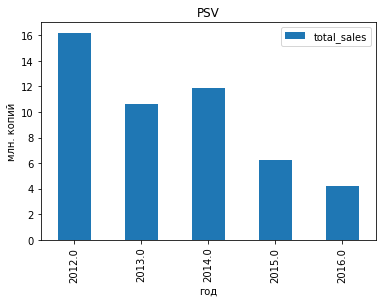

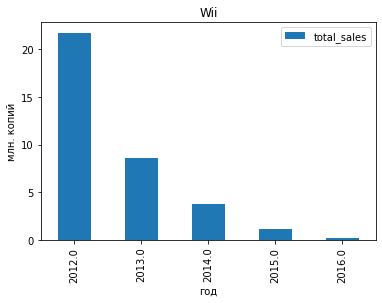

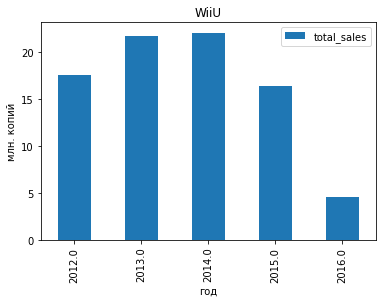

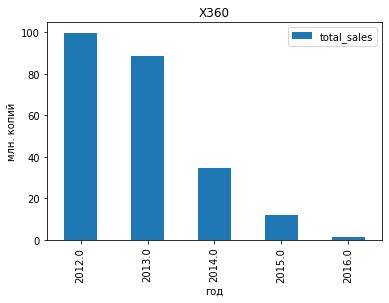

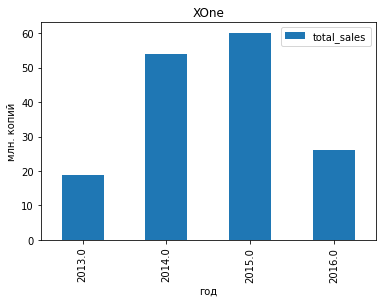

In [27]:
pivot_platform = rel_games_df.pivot_table(index=['platform', 'year_of_release'], values='total_sales', aggfunc='sum') #создаем сводную таблицу сгруппированную по платформе и году релиза игр со значениями общих продаж, чтобы определить потенциально прибыльные платформы
pivot_platform.reset_index(inplace=True)
for name, group in pivot_platform.groupby('platform'):
    group.plot(x='year_of_release', y='total_sales', kind='bar') #строим столбчатые диаграммы для каждой платформы
    plt.title(name)
    plt.xlabel('год')
    plt.ylabel('млн. копий')

Как видно из столбчатых диграмм в фазе роста (2016 не берем в расчет, так как данные за этот год получены не полностью) находятся только две платформы - PS4 и XOne, отстальные либо уже утратили актуальность, либо находятся в фазе падения продаж

### Глобальные продажи игр в разбивке по платформам за актуальный период

Для оценки глобальных продаж используем диаграмму размаха

(0.0, 2.0)

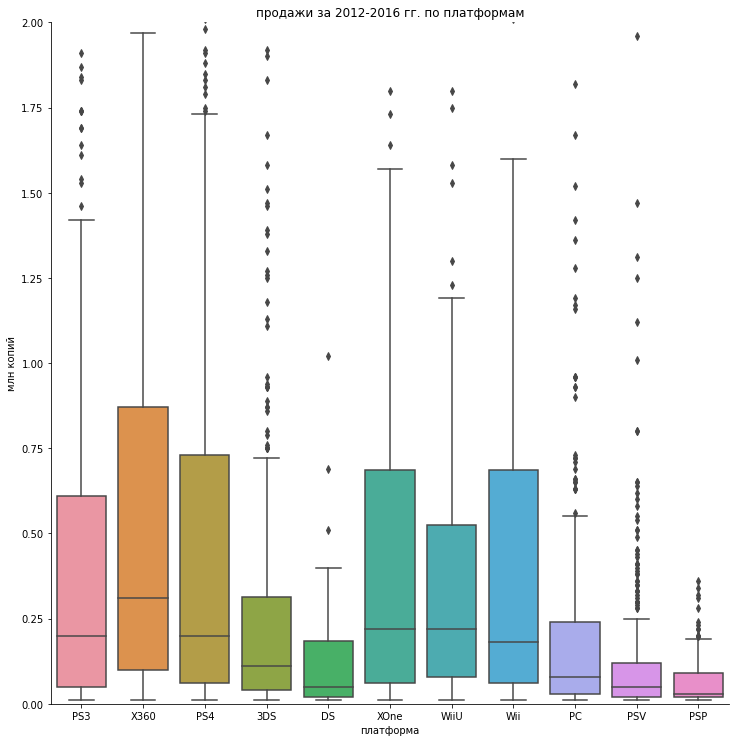

In [28]:
sns.catplot(x='platform', y='total_sales', data=rel_games_df, kind='box', height=10)
plt.title('продажи за 2012-2016 гг. по платформам')
plt.xlabel('платформа')
plt.ylabel('млн копий')
plt.ylim(0, 2)

На диаграммах размаха можно увидеть, что в большинстве своем продажи игр не превышают 2 млн копий, однако есть очень популярные игры с продажами в десятки миллионов.

### Оценка влияния отзывов пользователей и критиков на продажи внутри платформы

Для примера возьмем платформу X360

In [29]:
x360_sales = rel_games_df.query('platform == "X360"') #создаем отдельный датафрейм с выбранной платформой

0.006163978646213326

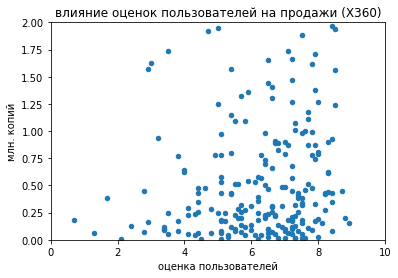

In [30]:
x360_sales.plot(x='user_score', y='total_sales', kind='scatter', title='влияние оценок пользователей на продажи (X360)', xlabel='оценка пользователей', ylabel='млн. копий') #строим диаграмму рассеивания
plt.xlim(0, 10)
plt.ylim(0, 2)
x360_sales['user_score'].corr(x360_sales['total_sales']) #считаем коэф. корреляции

0.3605734888507336

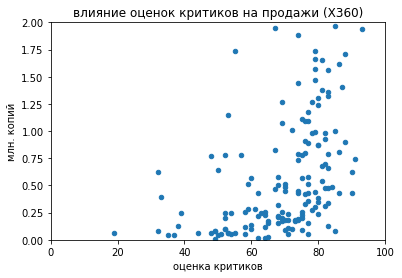

In [31]:
x360_sales.plot(x='critic_score', y='total_sales', kind='scatter', title='влияние оценок критиков на продажи (X360)', xlabel='оценка критиков', ylabel='млн. копий') #строим диаграмму рассеивания
plt.xlim(0, 100)
plt.ylim(0, 2)
x360_sales['critic_score'].corr(x360_sales['total_sales']) #считаем коэф. корреляции

Как видим из диаграмм рассеяния корреляции между отзывами пользователей и продажами на платформе X360 нет (коэф. корреляции 0,006), а взаимосвязь между оценками критиков и продажами прослеживается (коэф. корреляции 0,36).

### Соотнесение выводов с продажами на других платформах

Построим графики рассеивания еще для нескольких популярных платформ

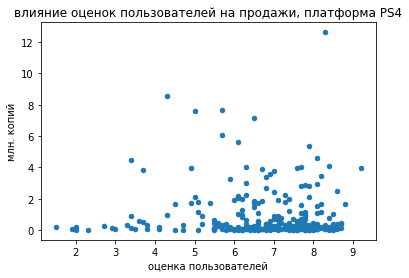

коэф. корреляции оценки пользователей - продажи: -0.031957110204556376


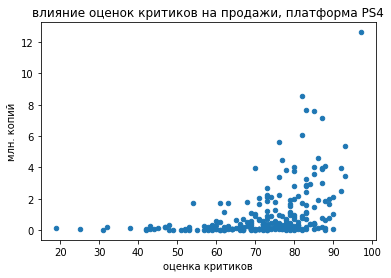

коэф. корреляции оценки критиков - продажи: 0.40656790206178095


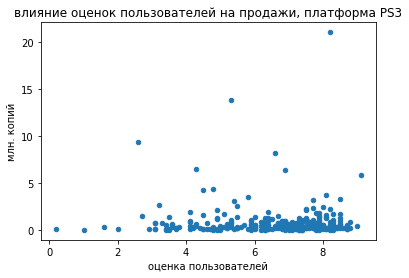

коэф. корреляции оценки пользователей - продажи: -0.006217851960559279


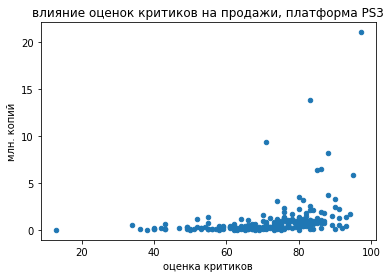

коэф. корреляции оценки критиков - продажи: 0.33416558787023765


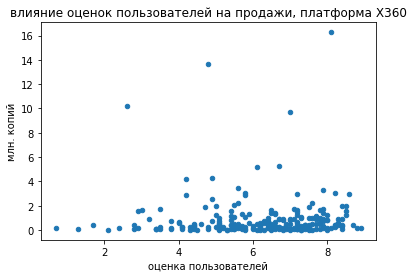

коэф. корреляции оценки пользователей - продажи: 0.006163978646213326


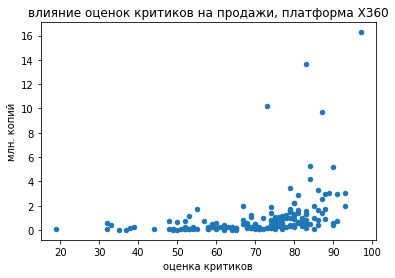

коэф. корреляции оценки критиков - продажи: 0.3605734888507336


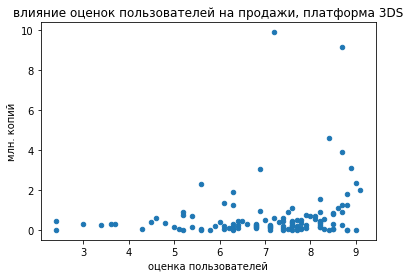

коэф. корреляции оценки пользователей - продажи: 0.19758263411038599


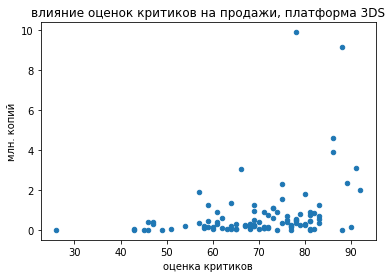

коэф. корреляции оценки критиков - продажи: 0.3208028695360785


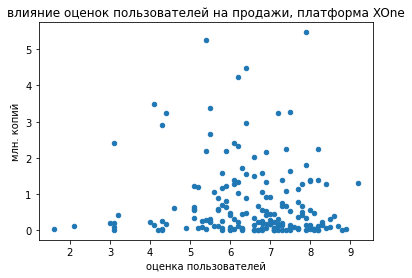

коэф. корреляции оценки пользователей - продажи: -0.06892505328279414


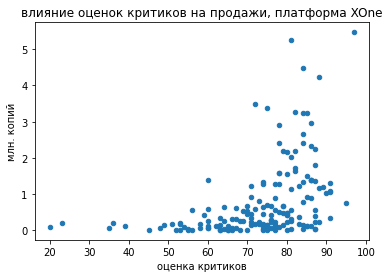

коэф. корреляции оценки критиков - продажи: 0.4169983280084017


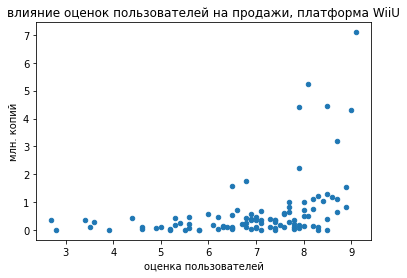

коэф. корреляции оценки пользователей - продажи: 0.4002190202148617


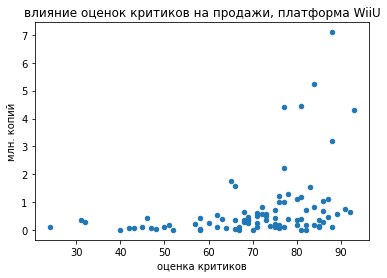

коэф. корреляции оценки критиков - продажи: 0.34837976012017485


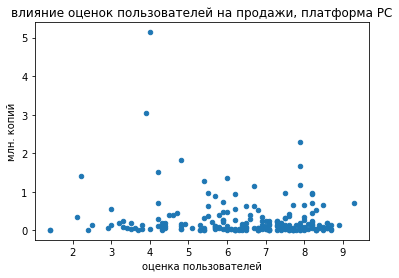

коэф. корреляции оценки пользователей - продажи: -0.12186747630735577


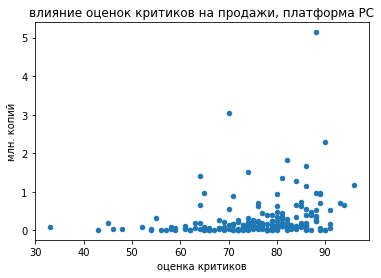

коэф. корреляции оценки критиков - продажи: 0.23724324311567915


In [32]:
rel_platform = ['PS4', 'PS3', 'X360', '3DS', 'XOne', 'WiiU', 'PC']
for name in rel_platform:
#for name in rel_games_df['platform'].unique():
    rel_games_df[rel_games_df['platform'] == name].plot(x='user_score', y='total_sales', kind='scatter', xlabel='оценка пользователей', ylabel='млн. копий')
    plt.title(f'влияние оценок пользователей на продажи, платформа {name}')
    plt.show()
    print('коэф. корреляции оценки пользователей - продажи:', rel_games_df[rel_games_df['platform'] == name]['user_score'].corr(rel_games_df[rel_games_df['platform'] == name]['total_sales']))
    rel_games_df[rel_games_df['platform'] == name].plot(x='critic_score', y='total_sales', kind='scatter', xlabel='оценка критиков', ylabel='млн. копий')
    plt.title(f'влияние оценок критиков на продажи, платформа {name}')
    plt.show()
    print('коэф. корреляции оценки критиков - продажи:', rel_games_df[rel_games_df['platform'] == name]['critic_score'].corr(rel_games_df[rel_games_df['platform'] == name]['total_sales']))

~Коэф. корреляций различаются в зависимости от платформы. Вывод по платформам PS3, PS4, XOne, PS2, GC, XB аналогичен выводу для платформы изученной отдельно - X360. Для платформ Wii, DS, 3DS, PC, PSP, PSV слабо прослеживается связь с продажами как для оценок пользователей, так и для оценок критиков, но коэф. корреляции все же выше у оценок критиков. Для платформы WiiU оценки пользователей больше коррелируют (коэф. корреляции 0,4) с продажами нежели оценки критиков (коэф. корреляции 0,35). Есть же и вовсе странная ситуация для платформы GBA, а именно, прослеживается сильная обратная взаимосвязь между оценками пользователей и продажами (коэф. корреляции -0,75), при этом оценки критиков не влияют на продажи (коэф. корреляции -0,18)~

На рассмотренных платформах прослеживается тенденция, что связи между оценками пользователей и объемами продаж нет, исключение составляет японская платформа WiiU где связь оценок пользователей с продажами даже выше, чем у оценок критиков. В других же кейсах ситуация схожа с платформой X360 рассмотренной отдельно, а именно, связь с оценками критиков есть, но она невелика

### Общее распределение игр по жанрам

Создаем сводную таблицу разбитую по жанрам с количественными характиристиками

In [33]:
genre = rel_games_df.pivot_table(index='genre', values='total_sales', aggfunc=['count', 'sum', 'mean', 'median'])
genre.columns = ['count', 'sum', 'mean', 'median']
genre.sort_values(by='count', ascending=False)

,count,sum,mean,median
genre,,,,
Action,1031,441.12,0.427856,0.120
Role-Playing,370,192.80,0.521081,0.140
Adventure,302,29.43,0.097450,0.030
Sports,267,181.07,0.678165,0.240
Shooter,235,304.73,1.296723,0.440
Misc,192,85.04,0.442917,0.120
Racing,115,53.50,0.465217,0.140
Fighting,109,44.49,0.408165,0.130
Platform,85,61.00,0.717647,0.210


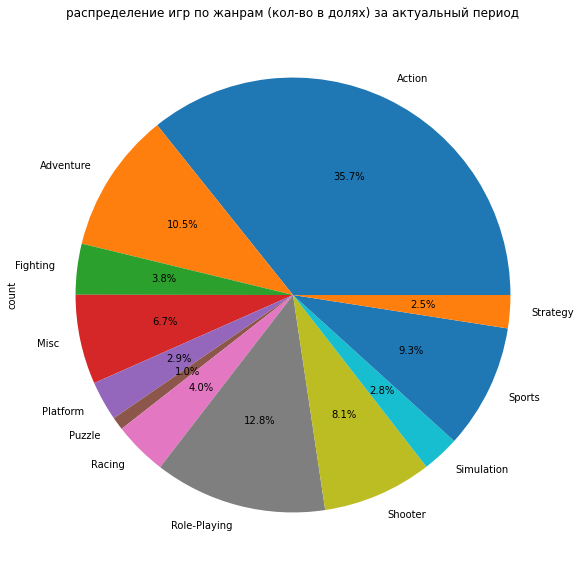

In [34]:
genre.plot(y='count', kind='pie', legend=False, title='распределение игр по жанрам (кол-во в долях) за актуальный период', autopct='%.1f%%', figsize=(10, 10))
plt.show()

### Исследование прибыли по жанрам

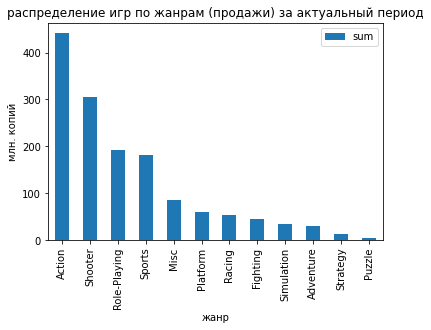

In [35]:
genre.sort_values(by='sum', ascending=False).plot(y='sum', kind='bar', title='распределение игр по жанрам (продажи) за актуальный период', xlabel='жанр', ylabel='млн. копий')
plt.show()

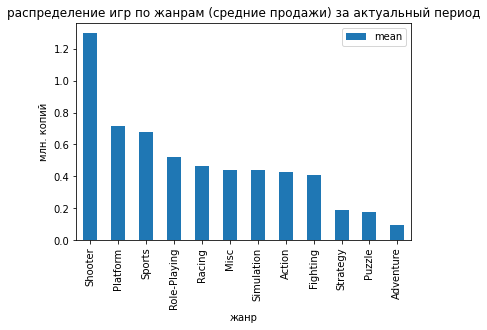

In [36]:
genre.sort_values(by='mean', ascending=False).plot(y='mean', kind='bar', title='распределение игр по жанрам (средние продажи) за актуальный период', xlabel='жанр', ylabel='млн. копий')
plt.show()

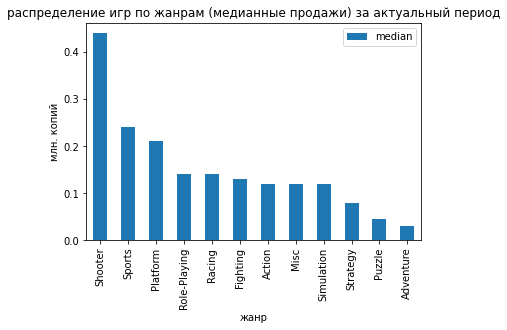

In [37]:
genre.sort_values(by='median', ascending=False).plot(y='median', kind='bar', title='распределение игр по жанрам (медианные продажи) за актуальный период', xlabel='жанр', ylabel='млн. копий')
plt.show()

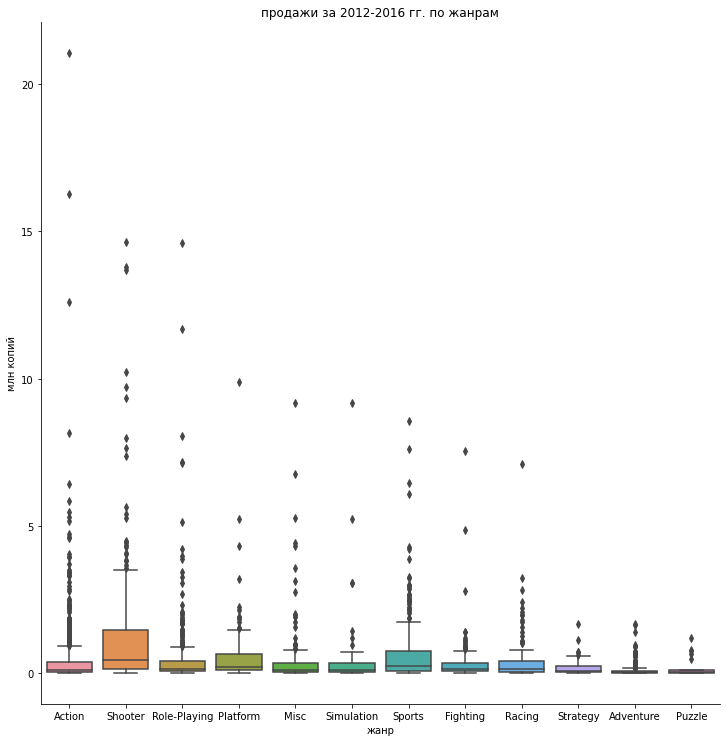

In [38]:
sns.catplot(x='genre', y='total_sales', data=rel_games_df, kind='box', height=10)
plt.title('продажи за 2012-2016 гг. по жанрам')
plt.xlabel('жанр')
plt.ylabel('млн копий')
plt.show()

~Наиболее популярный жанр 'Action'. Он лидирует как и по кол-ву вышедших игр, так и по кол-ву проданных копий. Далее по кол-ву вышедших игр расположились жанры 'Sports', 'Misc', 'Adventure', 'Role-Playing'. По кол-ву проданных копий после жанра 'Action' сформировался следующий топ: 'Sports', 'Shooter', 'Misc', 'Role-Playing'. Самые неприбыльные жанры: 'Strategy', 'Puzzle', 'Adventure'. Стоит выделить жанр 'Shooter', игры в этом жанре приносят больше всех прибыли за ед. релиза игры.~

Жанр 'Shooter' является самым прибыльным. Далее с практически двукратным отставанием идут жанры 'Sports', 'Platform'. Лидер же по продажам жанр 'Action' имеет достаточно невысокую медианную цену. В арьергарде списка как по кол-ву проданных копий, так и по прибыльности находятся жанры: 'Strategy', 'Puzzle', 'Adventure'.

## Портрет пользователя каждого региона

Пояснение для ESRB рейтинга:  
<b>EC</b> - для детей младшего возраста  
<b>E</b> - для всех  
<b>Е10+</b> - для всех от 10 лет и старше  
<b>T</b> - подросткам (от 13 лет)  
<b>М</b> - для взрослых (от 17 лет)  
<b>RP</b> - рейтинг ожидается

Определяем для каждого региона топ-5 популярных платформ, топ-5 популярных жанров и влияние рейтинга ESRB на продажи

### Регион NA

In [39]:
reg_na_plat = rel_games_df.pivot_table(index='platform', values='na_sales', aggfunc='sum')
total_sum_na = reg_na_plat['na_sales'].sum()
round(reg_na_plat['na_sales'].sort_values(ascending=False) / total_sum_na, 3).head() * 100 #топ-5 платформ в долях продаж региона NA 

platform
X360    23.7
PS4     18.4
PS3     17.5
XOne    15.8
3DS      9.4
Name: na_sales, dtype: float64

In [40]:
reg_na_genre = rel_games_df.pivot_table(index='genre', values='na_sales', aggfunc='sum')
round(reg_na_genre['na_sales'].sort_values(ascending=False) / total_sum_na, 3).head() * 100 #топ-5 жанров игр в долях продаж региона NA

genre
Action          30.1
Shooter         24.5
Sports          13.8
Role-Playing    10.8
Misc             6.5
Name: na_sales, dtype: float64

In [41]:
reg_na_rating = rel_games_df.pivot_table(index='rating', values='na_sales', aggfunc='sum')
round(reg_na_rating['na_sales'].sort_values(ascending=False) / total_sum_na, 3) * 100 #доли продаж в зависимости от рейтинга ESRB региона NA

rating
M       39.2
E       19.4
E10+    12.8
T       11.2
Name: na_sales, dtype: float64

Для региона NA лидером среди платформ стала X360 (23,7%), что, в целом, логично, так как производитель этой платформы американский. В жанровом топе лидирует 'Action' (30,1%). Больше всего проданных игр с категорией М (39,2%)

### Регион EU

In [42]:
reg_eu_plat = rel_games_df.pivot_table(index='platform', values='eu_sales', aggfunc='sum')
total_sum_eu = reg_eu_plat['eu_sales'].sum()
round(reg_eu_plat['eu_sales'].sort_values(ascending=False) / total_sum_eu, 3).head() * 100 #топ-5 платформ в долях продаж региона EU

platform
PS4     27.8
PS3     21.1
X360    14.7
XOne    10.2
3DS      8.4
Name: eu_sales, dtype: float64

In [43]:
reg_eu_genre = rel_games_df.pivot_table(index='genre', values='eu_sales', aggfunc='sum')
round(reg_eu_genre['eu_sales'].sort_values(ascending=False) / total_sum_eu, 3).head() * 100 #топ-5 жанров игр в долях продаж региона EU

genre
Action          31.4
Shooter         22.4
Sports          13.6
Role-Playing     9.6
Racing           5.4
Name: eu_sales, dtype: float64

In [44]:
reg_eu_rating = rel_games_df.pivot_table(index='rating', values='eu_sales', aggfunc='sum')
round(reg_eu_rating['eu_sales'].sort_values(ascending=False) / total_sum_eu, 3) * 100 #доли продаж в зависимости от рейтинга ESRB региона EU

rating
M       38.3
E       22.3
E10+    10.9
T       10.4
Name: eu_sales, dtype: float64

Для региона EU лидером среди платформ стала PS4 (27,8%). В жанрах ситуация аналогична региону NA - лидер категория М (38,3%). И с категориями те же дела: М лидирует с 38,3%.

### Регион JP

In [45]:
reg_jp_plat = rel_games_df.pivot_table(index='platform', values='jp_sales', aggfunc='sum')
total_sum_jp = reg_jp_plat['jp_sales'].sum()
round(reg_jp_plat['jp_sales'].sort_values(ascending=False) / total_sum_jp, 3).head() * 100 #топ-5 платформ в долях продаж региона JP

platform
3DS     45.6
PS3     18.3
PSV     10.9
PS4      8.3
WiiU     6.8
Name: jp_sales, dtype: float64

In [46]:
reg_jp_genre = rel_games_df.pivot_table(index='genre', values='jp_sales', aggfunc='sum')
round(reg_jp_genre['jp_sales'].sort_values(ascending=False) / total_sum_jp, 3).head() * 100 #топ-5 жанров игр в долях продаж региона JP

genre
Role-Playing    34.0
Action          27.4
Misc             6.7
Simulation       5.4
Fighting         4.9
Name: jp_sales, dtype: float64

In [47]:
reg_jp_rating = rel_games_df.pivot_table(index='rating', values='jp_sales', aggfunc='sum')
round(reg_jp_rating['jp_sales'].sort_values(ascending=False) / total_sum_jp, 3) * 100 #доли продаж в зависимости от рейтинга ESRB региона JP

rating
E       14.7
T       13.5
M       11.0
E10+     4.3
Name: jp_sales, dtype: float64

In [48]:
# Комментарий ревьюера
temp = rel_games_df.copy()
print(temp.rating.isna().sum(), temp.rating.isna().sum()/len(temp))
temp.rating.value_counts(dropna=False)

1275 0.44194107452339687


NaN     1275
M        498
T        412
E        394
E10+     306
Name: rating, dtype: int64

У региона JP топ платформа это 3DS (45,6%), все логично -> японская платформа захватила свой же рынок. В жанрах регион JP удивляет: топ жанр является Role-Playing (34%). Предполагаю, что это может быть связано с монополистом в лице Nintendo и ее платформами, которая делала акцент на играх этого жанра. В категориях тоже есть отличия от регионов NA и EU: на первом категория E (14,7%), а лидер в других регионах, категория М, забирает значительно меньшую долю продаж - 11%. Могу предположить, что это связано с тем, что в Японии игры прежде всего создавались для детей. Плюс ко всему в этом регионе очень большая доля игр без рейтинга ESRB (более 50%)

Основной вывод, который можно сделать это то, что игровая индустрия в регионе JP сильно отличается от регионов NA и EU, которые во многом схожи.

## Проверка гипотез

Гипотеза: <b>Средние пользовательские рейтинги платформ Xbox One и PC одинаковые</b>

Здесь используем двустороннюю гипотезу о равенстве средних двух независимых генеральных совокупностей  
H<sub>0</sub>: cредние пользовательские рейтинги платформ Xbox One и PC одинаковые  
H<sub>1</sub>: cредние пользовательские рейтинги платформ Xbox One и PC неодинаковые

In [49]:
xone_stat = rel_games_df.query('platform == "XOne"')['user_score'].dropna()
pc_stat = rel_games_df.query('platform == "PC"')['user_score'].dropna()
display(xone_stat.describe())
pc_stat.describe()

count    182.000000
mean       6.521429
std        1.380941
min        1.600000
25%        5.800000
50%        6.800000
75%        7.500000
max        9.200000
Name: user_score, dtype: float64

count    206.000000
mean       6.428641
std        1.664465
min        1.400000
25%        5.500000
50%        6.800000
75%        7.700000
max        9.300000
Name: user_score, dtype: float64

P.S. без метода dropna() p-value принимал значение NaN, почему это происходило я не разобрался

In [50]:
alpha = .05 #уровень статистической значимости

results = st.ttest_ind(xone_stat, pc_stat)

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение: 0.5535080500643661
Нет оснований отвергнуть нулевую гипотезу


~Есть основания говорить, что cредние пользовательские рейтинги платформ Xbox One и PC различны (хотя смотря какую значимость выставить)~

Есть основания полагать, что cредние пользовательские рейтинги платформ Xbox One и PC одинаковы

Гипотеза: <b>Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.</b>

Здесь тоже используем двустороннюю гипотезу о равенстве средних двух независимых генеральных совокупностей  
H<sub>0</sub>: cредние пользовательские рейтинги жанров Action и Sports одинаковые  
H<sub>1</sub>: cредние пользовательские рейтинги жанров Action и Sports неодинаковые

In [51]:
action_stat = rel_games_df.query('genre == "Action"')['user_score'].dropna()
sports_stat = rel_games_df.query('genre == "Sports"')['user_score'].dropna()
display(action_stat.describe())
sports_stat.describe()

count    523.000000
mean       6.825048
std        1.374440
min        1.600000
25%        6.250000
50%        7.100000
75%        7.800000
max        9.100000
Name: user_score, dtype: float64

count    194.000000
mean       5.455670
std        1.743142
min        0.200000
25%        4.300000
50%        5.750000
75%        6.800000
max        8.800000
Name: user_score, dtype: float64

In [52]:
alpha = .05 #уровень статистической значимости

results = st.ttest_ind(sports_stat, action_stat)

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение: 4.8045233804629176e-26
Отвергаем нулевую гипотезу


Есть основания говорить, что cредние пользовательские рейтинги жанров Action и Sports различны

## Общий вывод

~В 21 веке кол-во выпущенных игр значительно увеличилось по сравнению с 20 веком. Основной пик релизов пришелся на 2008-2009 года, после этого периода идет спад. Спад возможно связан с развитием мобильных игр. В целом рынок видеоигр подвержен сильным изменениям (продукты этой сферы имеют склонность к быстрому устареванию), т.к. относится к сектору информационных технологий. В среднем срок актуальности платформы составляет 9-10 лет, после этого платформа устаревает (PC пока живет вечно).  
На период полученных исходных данных в фазе роста продаж находятся только две платформы - PS4 и XOne, отстальные либо уже утратили актуальность, либо находятся в фазе падения продаж. В большинстве случаев продажи игр не превышают 2 млн копий, однако есть очень популярные игры с продажами в десятки миллионов.  
На рассмотренном примере платформы X360 корреляции между отзывами пользователей и продажами нет (коэф. корреляции 0,12), но прослеживается небольшая прямая взаимосвязь между оценками критиков и продажами (коэф. корреляции 0,4). Если говорить в целом, то коэф. корреляций данных пар показателей различаются в зависимости от платформы. Вывод по платформам PS3, PS4, XOne, PS2, GC, XB аналогичен выводу для платформы изученной отдельно - X360. Для платформ Wii, DS, 3DS, PC, PSP, PSV слабо прослеживается связь с продажами как для оценок пользователей, так и для оценок критиков, но коэф. корреляции все же выше у оценок критиков. Для платформы WiiU оценки пользователей больше коррелируют (коэф. корреляции 0,4) с продажами нежели оценки критиков (коэф. корреляции 0,35). Есть же и вовсе странная ситуация для платформы GBA, а именно, прослеживается сильная обратная взаимосвязь между оценками пользователей и продажами (коэф. корреляции -0,75), при этом оценки критиков не влияют на продажи (коэф. корреляции -0,18).  
Наиболее популярный жанр игр - 'Action'. Он лидирует как и по кол-ву вышедших игр, так и по кол-ву проданных копий. Самые не прибыльные жанры: 'Strategy', 'Puzzle', 'Adventure'. Также стоит выделить жанр 'Shooter', игры в этом жанре приносят больше всех прибыли за ед. релиза игры.
Для региона NA лидером среди платформ стала X360 (24,7%), что, в целом, логично, так как производитель этой платформы американский. В жанровом топе с отрывом лидирует 'Action' (22,2%). Категория (Е) охватывающая большую аудиторию нежели другие категории лидирует в регионе собрав 33,4% продаж. Для региона EU лидером среди платформ стала PS3 (21,9%). В жанрах ситуация аналогична региону NA, только отрыв еще чуть больше (23,4% против 16,8% у жанра Sports). И с категориями те же дела: E лидирует с 30,8%. У региона JP топ платформа это DS (25,2%), затем идет преемница 3DS (17,9%), все логично -> японские платформы захватили свой же рынок. В жанрах регион JP удивляет: топ жанр с огромным отрывом (30,4% против 18,2% у Action на втором месте) является Role-Playing. Предполагаю, что это может быть связано с монополистом в лице Nintendo и ее платформами, которая делала акцент на играх этого жанра. В категориях тоже есть отличия от регионов NA и EU: на первом месте как и везде категория E (21,4%), обращает на себя внимание категория М, которая забирает значительно меньшую долю продаж - 7,8%. В других регионах эта категория составляла около четверти от всех продаж. Могу предположить, что это связано с тем, что в Японии игры прежде всего создавались для детей. Плюс ко всему в этом регионе очень большая доля игр без рейтинга ESRB (около 50%). Основной вывод, который можно сделать это то, что игровая индустрия в регионе JP сильно отличается от регионов NA и EU.~

В исходном датафрейме 11 столбцов и 16715 строк. Пропущенные значения есть в столбцах 'Name', 'Year_of_Release', 'Genre', 'Critic_Score', 'User_Score', 'Rating'. Cтолбец с оценкой пользователя (User_Score) следует привести к типу float (в нем есть строковые значения).

На этапе предобработки данных названия столбцов приведены к нижнему регистру, найдены и обработаны неявные дубликаты, обработана аббревиатура 'tbd' в столбце с оценкой пользователей, были подсчитаны суммарные продажи и записаны в отдельный столбец 'total_sales'.
   
Этап анализа. В исходном датафрейме представлены данные о релизах игр в период 1980-2016 гг. Основной пик релизов пришелся на 2008-2009 года, после этого периода идет спад. Рынок видеоигр подвержен сильным изменениям (продукты этой сферы имеют склонность к быстрому устареванию), поэтому данные за все периоды не важны. В связи с этим, было принято решение взять актуальный период 5 лет. Срок жизни игровой платформы в среднем составляет 7 лет. На 2016 г. в фазе роста находятся две платформы - PS4 и XOne, отстальные уже утратили актуальность. В общей массе продажи игр не превышают 2 млн копий, однако есть очень популярные игры с продажами в десятки миллионов. Связи между оценками пользователей и объемами продаж в общем случае не наблюдается. Есть прямая связь продаж с оценками критиков, но она невелика. Жанр 'Shooter' является самым прибыльным. Далее с практически двукратным отставанием идут жанры 'Sports', 'Platform'. Лидер же по продажам жанр 'Action' имеет достаточно невысокую медианную цену. В арьергарде списка как по кол-ву проданных копий, так и по прибыльности находятся жанры: 'Strategy', 'Puzzle', 'Adventure'.

Портрет пользователя. Регион NA - платформа X360/PS4, жанр Action/Shooter, есть влияние рейтинга ESRB; регион EU - платформа PS4, жанр Action/Shooter, ESRB не влияет; регион JP - платформа 3DS/PS4, жанр Role-Playing/Action, ESRB не влияет.

Проверка гипотез.
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые - есть основания полагать, что это действительно так
2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные - есть основания полагать, что это действительно так